# Example 1 - Detection and quantification in Brightfield

xxx

## 1. Imports

In [1]:
import sys
sys.path.insert(0, "../") # Adds the module to path
import deeptrack as dt

In [2]:
import deeplay as dl

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Detection in brightfield

xxx

In [4]:
data = np.load("../data/brightfield_data.npy")
labels = np.load("../data/brightfield_labels.npy")

In [5]:
#Subtracting mean in the real part so that the data is centered
data[...,0] = data[...,0] - 1

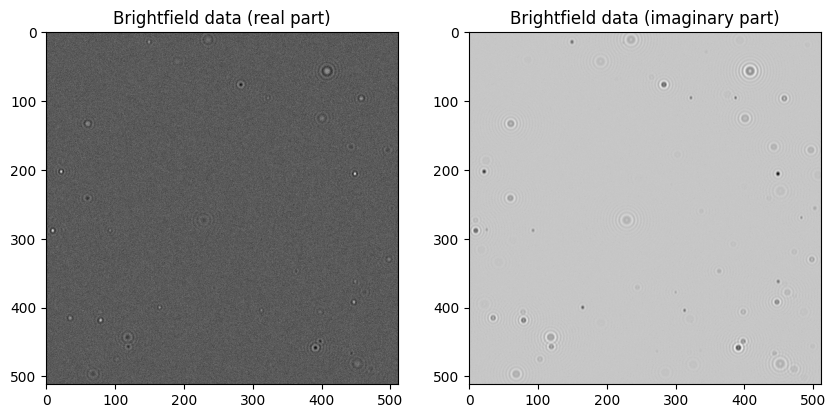

In [6]:
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.imshow(data[...,0], cmap="gray")
plt.title("Brightfield data (real part)")
plt.subplot(122)
plt.imshow(data[...,1], cmap="gray")
plt.title("Brightfield data (imaginary part)")
plt.show()

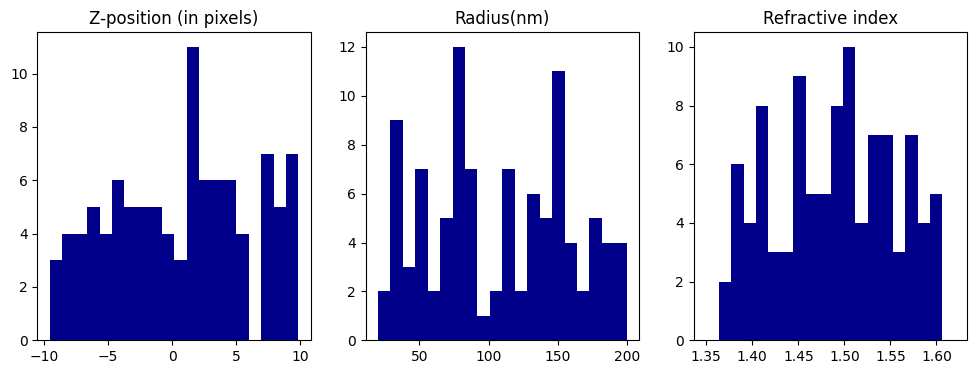

In [7]:
#Subplot of the distribution of the labels
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(labels[:,2], bins=20, color = 'darkblue')
plt.title("Z-position (in pixels)")
plt.subplot(132)
plt.hist(labels[:,3]*1e9, bins=20, color = 'darkblue', range=(20, 200))
plt.title("Radius(nm)")
plt.subplot(133)
plt.hist(labels[:,4], bins=20, color = 'darkblue', range=(1.35, 1.62))
plt.title("Refractive index")
plt.show()


### 2.1 Detecting particles using a classical method


#### 2.1.1 - Radial Variance Transform
xxx

In [8]:
import rvt # We import the radial variance method. Cite xxx
import skimage

In [9]:
#Apply Radial Variance Transform of image
rmin, rmax = 4, 25

def rvt_pipeline(data, rmin = 4, rmax = 25, th_scale = 0.3, min_distance = 5):
    
    #Apply Radial Variance Transform of image
    det = rvt.rvt(data[...,1], rmin = rmin, rmax = rmax)

    #Local max of the transformed image.
    blobs = skimage.feature.peak_local_max(det, min_distance=min_distance)
    blobs = np.stack([blobs[:,0], blobs[:,1]], axis=-1)

    #Extract detections that have a high enough value
    detections = []
    th = np.mean(det)*th_scale
    for blob in blobs:
        if np.mean(det[blob[0]-2:blob[0]+2, blob[1]-2:blob[1]+2]) > th:
            detections.append(blob)

    #Convert to numpy array and rename
    detections_rvt = np.array(detections)
    return detections_rvt

In [10]:
detections_rvt = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = 0.3)

#### 2.1.2 - Visualizing the detections from RVT
xxx

Text(0.5, 1.0, 'Detections with Radial Variance Transform')

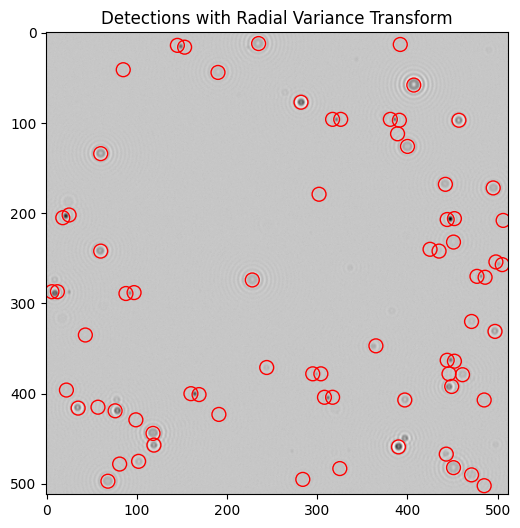

In [11]:
plt.figure(figsize=(6,6))
plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections_rvt[:,1], detections_rvt[:,0], s = 100, facecolors='none', edgecolors='r')
plt.title("Detections with Radial Variance Transform") 

### 2.2 Detecting particles using LodeSTAR model

xxx

#### 2.2.1  Prepare the Training Crop
We will use a single crop of a single particle to train the neural network.

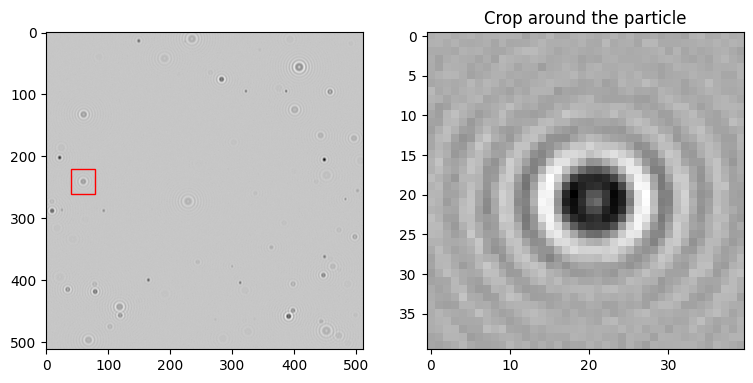

In [12]:
import matplotlib.patches as patches

crop_size = 40
labels_idx = 14

# We crop the image around the particle (based on the labels) - One could also use the detections or manually select a particle.
crop_x0 = int(labels[labels_idx, 0] - crop_size/2)
crop_y0 = int(labels[labels_idx, 1] - crop_size/2)

crop = data[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size, :]

plt.figure(figsize=(9, 6))

plt.subplot(1, 2, 1)
plt.imshow(data[...,1], cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

plt.subplot(1, 2, 2)
plt.title("Crop around the particle")
plt.imshow(crop[...,1], cmap="gray")

plt.show()

#### 2.2.1  Prepare pipeline and train model
We will create a pipeline for training the LodeSTAR model

In [13]:
IMAGE_SIZE = 40
PADDING = 64
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7


#For z-propagation
crop_propagation_forward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, 1e-7, RESOLUTION, WAVELENGTH)
crop_propagation_backward = dt.get_propagation_matrix((IMAGE_SIZE + PADDING, ) * 2, -1e-7, RESOLUTION, WAVELENGTH)


##################################
import numpy as np
import torch

training_pipeline = (
    dt.Value(crop)
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, lambda:np.random.randint(-10, 10)) 
    >> dt.InverseFourierTransform() 
    >> dt.Multiply(lambda: np.random.uniform(0.1, 3))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 1e-3)
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, 
                                      replace=False)

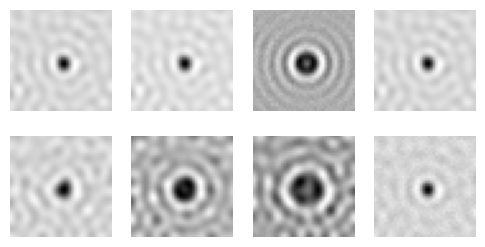

In [14]:
dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

batch = next(iter(dataloader))
#Visualize a batch
plt.figure(figsize=(6, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i,1], cmap="gray")
    plt.axis("off")

In [15]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=400)
trainer.fit(lodestar, dataloader)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-------------------------------------------------------------

Epoch 399: 100%|██████████| 50/50 [00:03<00:00, 13.94it/s, v_num=15, train_between_image_disagreement_step=0.027, train_within_image_disagreement_step=0.0163, train_between_image_disagreement_epoch=0.0353, train_within_image_disagreement_epoch=0.0153]    


#### 2.2.1  Visualize result from trained LodeSTAR model

xxx

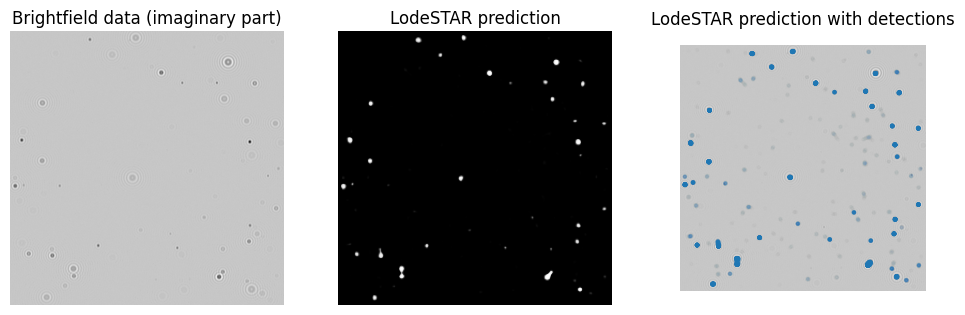

In [16]:

torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Brightfield data (imaginary part)")
plt.imshow(data[...,1], cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("LodeSTAR prediction")
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("LodeSTAR prediction with detections")
plt.imshow(data[...,1], cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

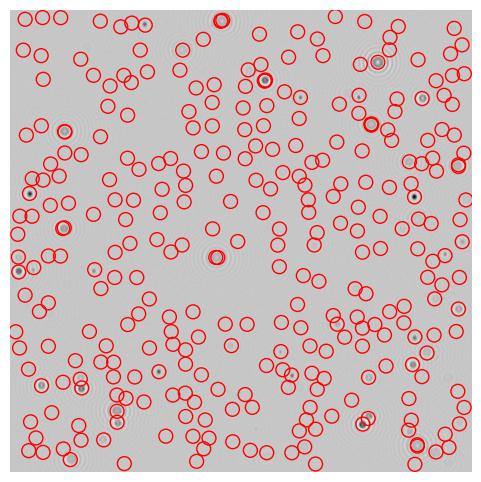

In [17]:
alpha = 0.5
beta = 0.5
cutoff = 0.90
mode = "quantile"#"constant"

plt.figure(figsize=(6, 6))
torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                mode=mode, cutoff=cutoff)[0]

plt.imshow(data[...,1], cmap="gray")
plt.scatter(detections[:,1], detections[:,0], s = 100, facecolors='none', edgecolors='r')
plt.axis("off")

plt.show()

### 2.3 Comparison between LodeSTAR and Radial Variance Transform

Both methods have a dependence on the threshold chosen. Down below we analyze the True Positive(TP), False Positive(FP), False Negative(FN) and the F1 Score, as well as constructing a ROC curve.

Obs, we denote that there are more dependencies outside the threshold and a gridsearch might give more accurate insights.

In [18]:
radius = 6 # Radius of the particle in pixels
centroids = labels[:, :2] # We use the labels as the ground truth
n_values = 250 # Number of values to test the threshold

# We create the arrays to store the results
TP_l, FP_l, FN_l, TN_l, F1_l = np.zeros(n_values), np.zeros(n_values), np.zeros(n_values), np.zeros(n_values), np.zeros(n_values)
TP_c, FP_c, FN_c, TN_c, F1_c = np.zeros(n_values), np.zeros(n_values), np.zeros(n_values), np.zeros(n_values), np.zeros(n_values)
mask = np.zeros_like(data[...,1])

In [19]:
def add_bin_circles(positions, radius, image):
    """Add circles to an image."""
    im = image.copy()
    for position in positions:
        rr, cc = skimage.draw.disk(position, radius)
        im[rr, cc] = 1
    return im

In [20]:
GT_particles = add_bin_circles(centroids, radius, mask)

Text(0.5, 1.0, 'Ground truth particles')

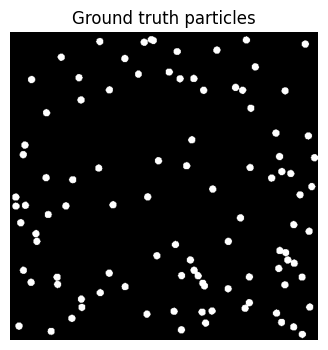

In [21]:
plt.figure(figsize=(4, 4))
plt.imshow(GT_particles, cmap="gray")
plt.axis("off")
plt.title("Ground truth particles")

In [22]:
### For LodeSTAR
cutoff_values_l = np.linspace(0, 1, n_values)

alpha = 0.5
beta = 0.3
mode = "quantile"

for i, cutoff in enumerate(cutoff_values_l):
    if i % 50 == 0 and i > 0: 
        print(f"Testing cutoff {i}/{n_values}")
    
    torch_image = torch.from_numpy(data).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                    mode=mode, cutoff=cutoff)[0]

    #Remove detections that are too close to the border with size radius
    detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                            (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # True positives - Overlap between the mask and the ground truth
    TP = np.sum(mask_tmp * GT_particles)
    # False positives - Detections that are not in the ground truth
    FP = np.sum(mask_tmp) - TP
    # False negatives - Ground truth particles that were not detected
    FN = np.sum(GT_particles) - TP
    # True negatives - Background that is correctly classified
    TN = np.sum((1 - mask_tmp) * (1 - GT_particles))
    # F1 score
    F1 = 2 * TP / (2 * TP + FP + FN)

    TP_l[i] = TP
    FP_l[i] = FP
    FN_l[i] = FN
    TN_l[i] = TN
    F1_l[i] = F1

Testing cutoff 50/250
Testing cutoff 100/250
Testing cutoff 150/250
Testing cutoff 200/250


In [23]:
### For RVT
cutoff_values_c = np.linspace(-0.5, 3, n_values)

for i, cutoff in enumerate(cutoff_values_c):
    if i % 50 == 0 and i > 0 : 
        print(f"Testing cutoff {i}/{n_values}")

    detections = rvt_pipeline(data, rmin = rmin, rmax = rmax, th_scale = cutoff)

    #Remove detections that are too close to the border with size radius
    detections = detections[(detections[:,0] > radius) & (detections[:,0] < data.shape[0] - radius) & 
                            (detections[:,1] > radius) & (detections[:,1] < data.shape[1] - radius)]

    # We create the mask with the detections
    mask_tmp = add_bin_circles(detections, radius, mask)

    # True positives - Overlap between the mask and the ground truth
    TP = np.sum(mask_tmp * GT_particles)
    # False positives - Detections that are not in the ground truth
    FP = np.sum(mask_tmp) - TP
    # False negatives - Ground truth particles that were not detected
    FN = np.sum(GT_particles) - TP
    # True negatives - Background that is correctly classified
    TN = np.sum((1 - mask_tmp) * (1 - GT_particles))
    # F1 score
    F1 = 2 * TP / (2 * TP + FP + FN)

    TP_c[i] = TP
    FP_c[i] = FP
    FN_c[i] = FN
    TN_c[i] = TN
    F1_c[i] = F1

Testing cutoff 50/250
Testing cutoff 100/250
Testing cutoff 150/250
Testing cutoff 200/250


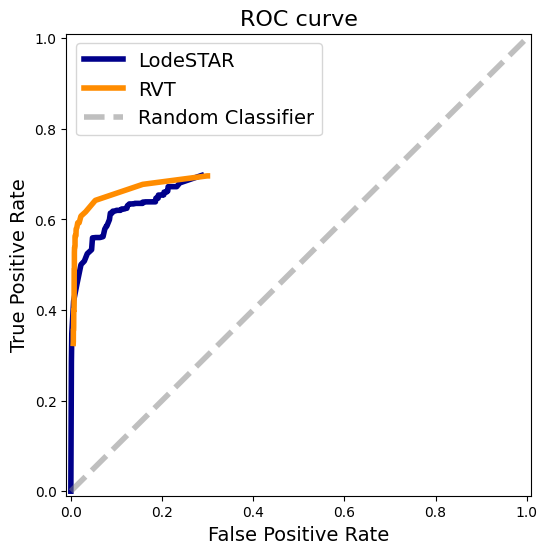

In [24]:
# ROC
TPR_l = TP_l / (TP_l + FN_l)
FPR_l = FP_l / (FP_l + TN_l)

TPR_c = TP_c / (TP_c + FN_c)
FPR_c = FP_c / (FP_c + TN_c)

plt.figure(figsize=(6, 6))
plt.plot(FPR_l, TPR_l, label="LodeSTAR", linestyle="-", color = 'darkblue', linewidth=4)
plt.plot(FPR_c, TPR_c, label="RVT", linestyle="-", color = 'darkorange', linewidth=4)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Classifier", linewidth=4, alpha = 0.5)
plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.legend(fontsize=14)
plt.xlabel("False Positive Rate", fontsize=14) 
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("ROC curve", fontsize=16)
plt.show()


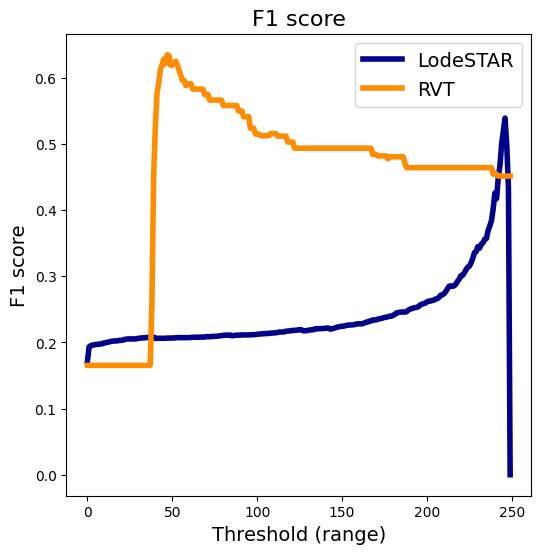

In [25]:
# F1 score
plt.figure(figsize=(6, 6))
plt.plot(np.arange(n_values), F1_l, label="LodeSTAR", linestyle="-", color = 'darkblue', linewidth=4)
plt.plot(np.arange(n_values), F1_c, label="RVT", linestyle="-", color = 'darkorange', linewidth=4)
plt.legend(fontsize=14)
plt.xlabel("Threshold (range)", fontsize=14)
plt.ylabel("F1 score", fontsize=14)
plt.title("F1 score", fontsize=16)
plt.show()

In [26]:
#Find the best threshold for LodeSTAR
idx_l = np.argmax(F1_l)
best_threshold_l = cutoff_values_l[idx_l]
print(f"Best threshold for LodeSTAR: {best_threshold_l}")
print(f"Best F1 score for LodeSTAR: {F1_l[idx_l]}")

#Find the best threshold for RVT
idx_c = np.argmax(F1_c)
best_threshold_c = cutoff_values_c[idx_c]
print(f"Best threshold for RVT: {best_threshold_c}")
print(f"Best F1 score for RVT: {F1_c[idx_c]}")

Best threshold for LodeSTAR: 0.9879518072289156
Best F1 score for LodeSTAR: 0.5393890675241158
Best threshold for RVT: 0.1606425702811245
Best F1 score for RVT: 0.6352881953183992


#### 2.3.1 Comparison between LodeSTAR and Radial Variance Transform - On individual ROIs

xxx


In [27]:
def get_rois(data, positions, padsize):
    """Function for retrieving ROIs from data. Obs - rounded to integers"""

    rois = []
    for pos in positions:
        #Check if the roi is out of bounds
        if pos[1]-padsize < 0 or pos[1]+padsize >= data.shape[0] or pos[0]-padsize < 0 or pos[0]+padsize >= data.shape[1]:
            continue

        roi = data[int(pos[0]-padsize):int(pos[0]+padsize), int(pos[1]-padsize):int(pos[1]+padsize),:]
        
        rois.append(roi)
    return np.stack(rois)

In [28]:
padsize = 20
rois = get_rois(data, centroids, padsize)

In [29]:
detections_rvt_rois = [rvt_pipeline(roi, rmin = rmin, rmax = rmax, th_scale = best_threshold_c) for roi in rois]

#If more than 1 detection, take out the one closest to center
detections_rvt_rois_new = []
for detections in detections_rvt_rois:
    if len(detections) > 1:
        distances = np.linalg.norm(detections - padsize, axis=1)
        detections = detections[np.argmin(distances)]
    detections_rvt_rois_new.append(detections)


In [30]:
detections_lodestar_rois = []

for roi in rois:
    torch_image = torch.from_numpy(roi).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                    mode=mode, cutoff=best_threshold_l)[0].astype(int)
    detections_lodestar_rois.append(detections)

#If more than 1 detection, take out the one closest to center
detections_lodestar_rois_new = []
for detections in detections_lodestar_rois:
    if len(detections) > 1:
        distances = np.linalg.norm(detections - padsize, axis=1)
        detections = detections[np.argmin(distances)]
    detections_lodestar_rois_new.append(detections)

c:\Users\Fredrik\miniconda3\envs\dt\lib\site-packages\scipy\signal\_signaltools.py:278: RuntimeWarning: invalid value encountered in cast
  z = _sigtools._correlateND(in1zpadded, in2, out, val)


In [31]:
th_pixels = 3

In [32]:
#Count how many particles that are correctly identified
correct_rvt = 0
for detection_rvt in detections_rvt_rois_new:
    if np.linalg.norm(detection_rvt - padsize) < th_pixels:
        correct_rvt += 1

correct_lodestar = 0
for detection_lodestar in detections_lodestar_rois_new:
    if np.linalg.norm(detection_lodestar - padsize) < th_pixels:
        correct_lodestar += 1

In [33]:
print(f"Correctly identified RVT: {correct_rvt}/{len(rois)} ({np.round(correct_rvt/len(rois)*100, 1)})%")
print(f"Correctly identified LodeSTAR: {correct_lodestar}/{len(rois)} ({np.round(correct_lodestar/len(rois)*100, 1)})%")

Correctly identified RVT: 46/82 (56.1)%
Correctly identified LodeSTAR: 45/82 (54.9)%


## 3 - Quantification of particle properties in Brightfield

xxx

In [34]:
padsize = 20
positions  = labels[:, :2]

#Extract positions that are not too close to the border
arg1 = (positions[:,0] > padsize) & (positions[:,0] < data.shape[0] - padsize) & (positions[:,1] > padsize) & (positions[:,1] < data.shape[1] - padsize)
positions = positions[arg1]

#Extract positions that do not overlap to close to eachother
distances = np.linalg.norm(positions[:, None] - positions, axis=-1)
arg2 = np.sum(distances < padsize*1.5, axis=0) == 1

#Extract the positions
positions = positions[arg2]

#Extract the labels
labels = labels[arg1][arg2]

In [35]:
rois = get_rois(data, positions, padsize)
rois.shape

(40, 40, 40, 2)

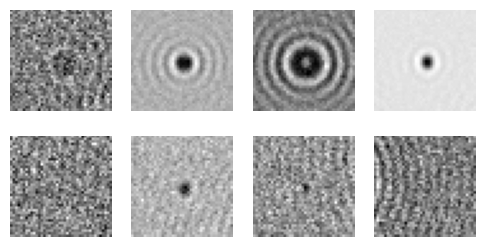

In [55]:
plt.figure(figsize=(6, 3))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(rois[i,...,1], cmap="gray")
    plt.axis("off")

### 3.1 Quantifying particle signal with a classical method

Gaussian fit

In [99]:
# Do a gaussian fit to the data and summarize the ROI
import numpy as np
from scipy.stats import norm
from scipy.stats import multivariate_normal

def gaussian_fit_and_sum(input_data):
    """Fit a 2D Gaussian distribution to the data."""
    # Get the dimensions of the image
    height, width = input_data.shape

    # Create meshgrid for the image coordinates
    x, y = np.meshgrid(np.arange(0, width), np.arange(0, height))

    # Stack the meshgrid coordinates
    data = np.column_stack((x.flatten(), y.flatten()))

    # Fit a 2D Gaussian distribution to the pixel intensity values
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    # Create a multivariate Gaussian distribution using the fitted parameters
    gaussian_distribution = multivariate_normal(mean=mean, cov=cov)

    # Evaluate the Gaussian distribution for each pixel value
    gaussian_values = gaussian_distribution.pdf(data)

    # Reshape the Gaussian values to the original image shape
    gaussian_values = gaussian_values.reshape((height, width))

    # Sum the pixel values weighted by the Gaussian values
    weighted_sum = np.sum(input_data * gaussian_values)

    return weighted_sum

In [123]:
signal_sum_gauss = np.array([gaussian_fit_and_sum(roi[...,1]) for roi in rois])

In [124]:
def get_polarizability(radius, refractive_index):
    """Calculate the polarizability of a particle."""

    return np.array(4/3 * np.pi * radius**3 * (refractive_index - 1.33))

In [125]:
polarizabilities = get_polarizability(labels[:,3], labels[:,4])

Text(0.5, 1.0, 'Polarizability vs Signal with gaussian fit')

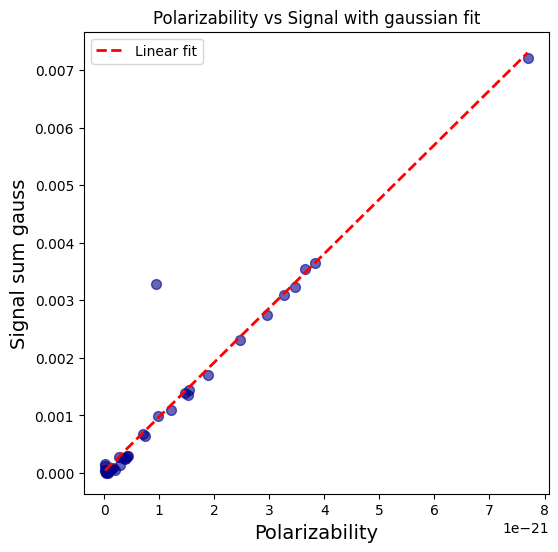

In [129]:
plt.figure(figsize=(6, 6))
plt.scatter(polarizabilities, np.abs(signal_sum_gauss), color="darkblue", alpha=0.6, s=50)
#line fit
coefficients = np.polyfit(polarizabilities, np.abs(signal_sum_gauss), 1)
polynomial = np.poly1d(coefficients)
x_axis = np.linspace(polarizabilities.min(), polarizabilities.max(), 100)
y_axis = polynomial(x_axis)
plt.plot(x_axis, y_axis, color="red", linestyle="--", linewidth=2, label="Linear fit")
plt.xlabel("Polarizability", fontsize=14)
plt.ylabel("Signal sum gauss", fontsize=14)
plt.legend()
plt.title("Polarizability vs Signal with gaussian fit")

### 3.2 Quantifying particle signal using a 2DCNN

#### 3.2.1 Defining the optical system

xxx

In [38]:
IMAGE_SIZE = 32
NA = 1.3
MAGNIFICATION = 1
WAVELENGTH = 633e-9
RESOLUTION = 1.14e-7

In [39]:
optics = dt.Brightfield(
    NA=NA,
    magnification=MAGNIFICATION,
    wavelength=WAVELENGTH,
    resolution=RESOLUTION,
    return_field=True, 
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

#### 3.2.2 Defining the particle(s)

In [40]:
RADIUS_RANGE = (25e-9, 200e-9)
REFRACTIVE_INDEX_RANGE = (1.37, 1.6)

In [41]:
particle = dt.MieSphere(
    position=lambda: (IMAGE_SIZE / 2, IMAGE_SIZE / 2) + np.random.rand(2) * 4 - 2,
    z=lambda: np.random.randn() * 2,
    radius=lambda:np.random.uniform(*RADIUS_RANGE),
    refractive_index=lambda: np.random.uniform(*REFRACTIVE_INDEX_RANGE),
    L=8,
    position_unit="pixel",
)

#### 3.2.3 Create dataset of particles

The noise is simulated as gaussian distributed noise, with independent real and imaginary parts. The amplitude of the noise is determined by the dummy property `level`, which is explicitly shared between the two features. Finally, the real and imaginary parts of the field are separated into two layers, and the plane wave is subtracted.

In [42]:
real_noise = dt.Gaussian(
    mu=0, 
    sigma=lambda: np.random.rand() * 0.03,
)

noise = real_noise >> dt.Gaussian(
    mu=0, 
    sigma=lambda real_sigma: real_sigma * 0.04j,
    real_sigma=real_noise.sigma
)

def func():
    def inner(image):
        image = image - 1
        output = np.zeros((*image.shape[:2], 2))
        output[..., 0:1] = np.real(image)
        output[..., 1:2] = np.imag(image)
        return output
    return inner


complex_to_float = dt.Lambda(func)

We now define how these objects combine. Note that the noise is added inside the optics. This means that it will have the same PSF as the sample, which is what is observed. 

In [43]:
noisy_dataset = optics(particle >> noise) >> complex_to_float
clean_dataset = optics(particle) >> complex_to_float

dataset = noisy_dataset & clean_dataset

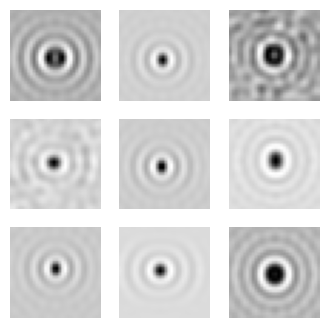

In [74]:
#3x3 grid of augmented images
plt.figure(figsize=(4, 4))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = dataset.update().resolve()
    plt.imshow(img[0][...,1], cmap="gray")
    plt.axis('off')

#### 3.3.4 Defining the training label

We extract the parameters we want the network to learn. This is the integrated signal.

In [45]:
def get_label(image):
    return np.array(np.sum(image[1][...,1]))

In [46]:
def get_polarizability(image):
    r = image[0].get_property("radius")
    n = image[0].get_property("refractive_index") - 1.33
    return np.array(4/3 * np.pi * r**3 * n)


In [47]:
def batch_function(image):
    return np.array(image[0])

### 3.3.5 Defining quantification model (2DCNN)
xxx

In [48]:
conv = dl.ConvolutionalEncoder2d(2, [16, 32], 64)
mlp = dl.MultiLayerPerceptron(None, [32, 32], 1)

net = dl.Sequential(
    conv,
    mlp
)


In [77]:
image_and_signal_pipeline = noisy_dataset &  (noisy_dataset >> dt.Lambda(get_label))

In [78]:
dataloader = dl.DataLoader(image_and_signal_pipeline, batch_size=32, shuffle=True)

TypeError: object of type 'Chain' has no len()

In [66]:
model = dl.Model(net, 
                 train_data=image_and_signal_pipeline,
                 val_data=image_and_signal_pipeline,
                 optimizer=dl.Adam(lr=1e-3),
                 loss=dl.torch.nn.L1Loss())

AttributeError: module 'deeplay' has no attribute 'Model'

### 3.3.6 Training quantification model
xxx

In [ ]:
N_samples = 256
Signal = []
Pol = []
Prediction = []

for n in range(N_samples):

    image = dataset.update().resolve()
    integrated_signal = get_label(image)
    polarizability = get_polarizability(image)

    prediction = model.predict(np.expand_dims(image[0], axis=0))

    Signal.append(integrated_signal)
    Pol.append(polarizability)
    Prediction.append(prediction[0])


In [ ]:
Signal = np.array(Signal)
Pol = np.array(Pol)
Prediction = np.array(Prediction)


In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Signal, Prediction, s=10)
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Pol, Prediction, s=10)
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(Pol, Signal, s=10)
plt.show()

## 4. Combining detection and quantification in brightfield